# Lesson 4: Data reclassification

- https://kodu.ut.ee/~kmoch/geopython2020/L4/reclassify.html

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

fp = "corine_tartu.shp"
data = gpd.read_file(fp)

In [2]:
%matplotlib inline

In [3]:
data.head(5)

,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry
0,111,EU-2024275,None,51.462132,4531.639281,514621.315450,"POLYGON Z ((5290566.200 4034511.450 0.000, 529..."
1,112,EU-2024328,None,25.389164,143.790405,153.109311,MULTIPOLYGON Z (((5259932.400 3993825.370 0.00...
2,112,EU-2024336,None,28.963212,2974.801106,289632.119850,"POLYGON Z ((5268691.710 3996582.900 0.000, 526..."
3,112,EU-2024348,None,54.482860,5546.791914,544828.603299,"POLYGON Z ((5270008.730 4001777.440 0.000, 526..."
4,112,EU-2024352,None,33.392926,4102.166244,333929.262851,"POLYGON Z ((5278194.410 4003869.230 0.000, 527..."


In [4]:
fp_clc = "corine_legend/clc_legend.csv"
data_legend = pd.read_csv(fp_clc, sep=';', encoding='latin1')
data_legend.head(5)

,GRID_CODE,CLC_CODE,LABEL3,RGB
0,1,111,Continuous urban fabric,230-000-077
1,2,112,Discontinuous urban fabric,255-000-000
2,3,121,Industrial or commercial units,204-077-242
3,4,122,Road and rail networks and associated land,204-000-000
4,5,123,Port areas,230-204-204


In [5]:
display(data.dtypes)
display(data_legend.dtypes)
# please don't actually do it right now, it might cause extra troubles later
# data = data.merge(data_legend, how='inner', left_on='code_12', right_on='CLC_CODE')


code_12         object
ID              object
Remark          object
Area_Ha        float64
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

GRID_CODE     int64
CLC_CODE      int64
LABEL3       object
RGB          object
dtype: object

In [6]:
def change_type(row):
    code_as_int = int(row['code_12'])
    return code_as_int

In [7]:
data['clc_code_int'] = data.apply(change_type, axis=1)
data.head(2)

,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry,clc_code_int
0,111,EU-2024275,None,51.462132,4531.639281,514621.315450,"POLYGON Z ((5290566.200 4034511.450 0.000, 529...",111
1,112,EU-2024328,None,25.389164,143.790405,153.109311,MULTIPOLYGON Z (((5259932.400 3993825.370 0.00...,112


In [8]:
data = data.merge(data_legend, how='inner', left_on='clc_code_int', right_on='CLC_CODE', suffixes=('', '_legend'))

In [9]:
selected_cols = ['ID','Remark','Shape_Area','CLC_CODE','LABEL3','RGB','geometry']

# Select data
data = data[selected_cols]

# What are the columns now?
data.columns

Index(['ID', 'Remark', 'Shape_Area', 'CLC_CODE', 'LABEL3', 'RGB', 'geometry'], dtype='object')

In [10]:
# Check coordinate system information
data.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
data_proj = data.to_crs(epsg=3301)
# Calculate the area of bogs
data_proj['area'] = data_proj.area

# What do we have?
data_proj['area'].head(2)

0    514565.037797
1       153.104211
Name: area, dtype: float64

<AxesSubplot:>

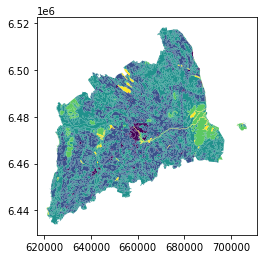

In [12]:
data_proj.plot(column='CLC_CODE', linewidth=0.05)

In [13]:
print(list(data_proj['CLC_CODE'].unique()))
print(list(data_proj['LABEL3'].unique()))

[111, 112, 121, 122, 124, 131, 133, 141, 142, 211, 222, 231, 242, 243, 311, 312, 313, 321, 324, 411, 412, 511, 512]
['Continuous urban fabric', 'Discontinuous urban fabric', 'Industrial or commercial units', 'Road and rail networks and associated land', 'Airports', 'Mineral extraction sites', 'Construction sites', 'Green urban areas', 'Sport and leisure facilities', 'Non-irrigated arable land', 'Fruit trees and berry plantations', 'Pastures', 'Complex cultivation patterns', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Broad-leaved forest', 'Coniferous forest', 'Mixed forest', 'Natural grasslands', 'Transitional woodland-shrub', 'Inland marshes', 'Peat bogs', 'Water courses', 'Water bodies']


In [14]:
bogs = data_proj.loc[data['LABEL3'] == 'Peat bogs'].copy()
bogs.head(2)

,ID,Remark,Shape_Area,CLC_CODE,LABEL3,RGB,geometry,area
2214,EU-2056784,None,4.772165e+05,412,Peat bogs,077-077-255,"POLYGON Z ((625609.433 6453543.495 0.000, 6255...",4.771837e+05
2215,EU-2056806,None,8.917057e+06,412,Peat bogs,077-077-255,"POLYGON Z ((631620.621 6465132.490 0.000, 6316...",8.916207e+06


In [15]:
bogs['area_km2'] = bogs['area'] / 1000000

# What is the mean size of our bogs?
l_mean_size = bogs['area_km2'].mean()
l_mean_size

2.155588679443975

Text(0.5, 1.0, 'Bogs area_km2 histogram')

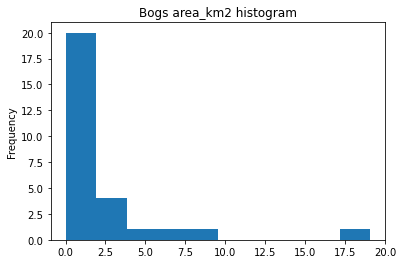

In [16]:
fig, ax = plt.subplots()

bogs['area_km2'].plot.hist(bins=10)

# Add title
plt.title("Bogs area_km2 histogram")

In [17]:
def binaryClassifier(row, source_col, output_col, threshold):
    # If area of input geometry is lower that the threshold value
    if row[source_col] < threshold:
        # Update the output column with value 0
        row[output_col] = 0
    # If area of input geometry is higher than the threshold value update with value 1
    else:
        row[output_col] = 1
    # Return the updated row
    return row

In [18]:
bogs['small_big'] = None

In [19]:
bogs = bogs.apply(binaryClassifier, source_col='area_km2', output_col='small_big', threshold=l_mean_size, axis=1)

<AxesSubplot:>

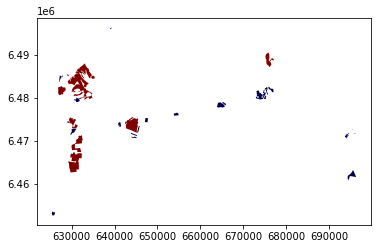

In [20]:
bogs.plot(column='small_big', linewidth=0.05, cmap="seismic")

## Classification based on common classification schemes

In [21]:
fp = "population_admin_units.shp"
acc = gpd.read_file(fp)

In [22]:
import pysal.viz.mapclassify as mc

In [23]:
# Define the number of classes
n_classes = 5

In [24]:
# Create a Natural Breaks classifier
classifier = mc.NaturalBreaks.make(k=n_classes)

In [25]:
acc.dtypes

VID            float64
KOOD            object
NIMI            object
population      object
geometry      geometry
dtype: object

In [26]:
import numpy as np

def change_type_defensively(row):
    try:
        return int(row['population'])
    except Exception:
        return np.nan
acc['population_int'] = acc.apply(change_type_defensively, axis=1)
acc.head(5)

,VID,KOOD,NIMI,population,geometry,population_int
0,41158132.0,0698,Rõuge vald,5435,"POLYGON ((646935.772 6394632.940, 647093.829 6...",5435
1,41158133.0,0855,Valga vald,15989,"POLYGON ((620434.776 6406412.852, 620687.169 6...",15989
2,41158134.0,0732,Setomaa vald,3369,"MULTIPOLYGON (((698977.677 6412793.362, 699094...",3369
3,41158135.0,0917,Võru vald,10793,"POLYGON ((656207.141 6413138.438, 656408.394 6...",10793
4,41158136.0,0142,Antsla vald,4514,"POLYGON ((640706.698 6417414.068, 641029.597 6...",4514


In [27]:
# Classify the data
acc['population_classes'] = acc[['population_int']].apply(classifier)

# Let's see what we have
acc.head()

,VID,KOOD,NIMI,population,geometry,population_int,population_classes
0,41158132.0,0698,Rõuge vald,5435,"POLYGON ((646935.772 6394632.940, 647093.829 6...",5435,0
1,41158133.0,0855,Valga vald,15989,"POLYGON ((620434.776 6406412.852, 620687.169 6...",15989,1
2,41158134.0,0732,Setomaa vald,3369,"MULTIPOLYGON (((698977.677 6412793.362, 699094...",3369,0
3,41158135.0,0917,Võru vald,10793,"POLYGON ((656207.141 6413138.438, 656408.394 6...",10793,1
4,41158136.0,0142,Antsla vald,4514,"POLYGON ((640706.698 6417414.068, 641029.597 6...",4514,0


<AxesSubplot:>

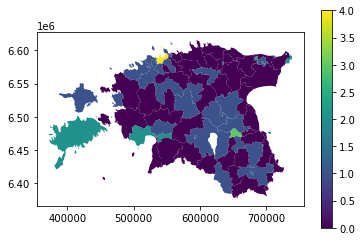

In [28]:
acc.plot(column="population_classes", linewidth=0, legend=True)

Text(0.5, 1.0, 'Amount of inhabitants column histogram')

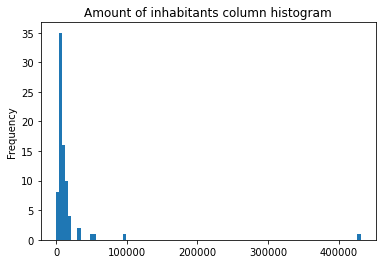

In [29]:
# Plot
fig, ax = plt.subplots()

acc["population_int"].plot.hist(bins=100);

# Add title
plt.title("Amount of inhabitants column histogram")

In [30]:
grouped = acc.groupby('population_classes')

# legend_dict = { 'class from to' : 'white'}
legend_dict = {}

for cl, valds in grouped:
    minv = valds['population_int'].min()
    maxv = valds['population_int'].max()
    print("Class {}: {} - {}".format(cl, minv, maxv))

Class 0: 141 - 8984
Class 1: 9387 - 21406
Class 2: 31205 - 56103
Class 3: 96506 - 96506
Class 4: 430805 - 430805


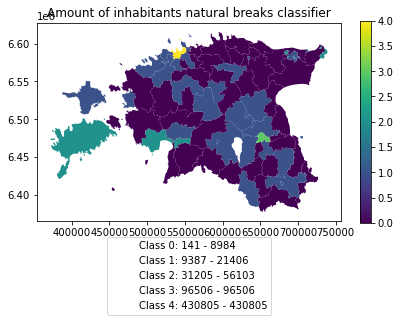

In [31]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import collections

# legend_dict, a special ordered dictionary (which reliably remembers order of adding things) that holds our class description and gives it a colour on the legend (we leave it "background" white for now)
legend_dict = collections.OrderedDict([])

for cl, valds in grouped:
    minv = valds['population_int'].min()
    maxv = valds['population_int'].max()
    legend_dict.update({"Class {}: {} - {}".format(cl, minv, maxv): "white"})
    
# Plot preps for several plot into one figure
fig, ax = plt.subplots()

# plot the dataframe, with the natural breaks colour scheme
acc.plot(ax=ax, column="population_classes", linewidth=0, legend=True)

# the custom "patches" per legend entry of our additional labels
patchList = []
for key in legend_dict:
    data_key = mpatches.Patch(color=legend_dict[key], label=key)
    patchList.append(data_key)

# plot the custom legend
plt.legend(handles=patchList, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=1)

# Add title
plt.title("Amount of inhabitants natural breaks classifier")

plt.tight_layout()